In [1]:
%reload_ext autoreload
%autoreload 1
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import functions.transformers as tr
import functions.data_manipulation_functions as dmf
import functions.plot_functions as pf
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

%aimport functions.transformers
%aimport functions.data_manipulation_functions
%aimport functions.plot_functions

In [2]:
BASE_FIG_SIZE=(8.5,4.5)
sns.set()

### Data Overview

In [3]:
data_accepted=pl.read_csv('data/accepted_2007_to_2018Q4.csv',dtypes={'id':str})

In [4]:
data_accepted['id'].is_duplicated().any()

False

In [5]:
data_rejected=pl.read_csv('data/rejected_2007_to_2018Q4.csv')

In [6]:
data_rejected.shape

(27648741, 9)

In [7]:
data_accepted.shape

(2260701, 151)

In [8]:
data_rejected.head()

Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
f64,str,str,f64,str,str,str,str,f64
1000.0,"""2007-05-26""","""Wedding Covere…",693.0,"""10%""","""481xx""","""NM""","""4 years""",0.0
1000.0,"""2007-05-26""","""Consolidating …",703.0,"""10%""","""010xx""","""MA""","""< 1 year""",0.0
11000.0,"""2007-05-27""","""Want to consol…",715.0,"""10%""","""212xx""","""MD""","""1 year""",0.0
6000.0,"""2007-05-27""","""waksman""",698.0,"""38.64%""","""017xx""","""MA""","""< 1 year""",0.0
1500.0,"""2007-05-27""","""mdrigo""",509.0,"""9.43%""","""209xx""","""MD""","""< 1 year""",0.0


### Join procedure

In [9]:
data_accepted = data_accepted.with_columns(pl.lit(np.int8(1)).alias('policy_code'))

In [10]:
data_rejected = data_rejected.with_columns(pl.lit(np.int8(0)).alias('Policy Code'))

In [11]:
data_rejected = data_rejected.with_columns(
    data_rejected["Debt-To-Income Ratio"]
    .map_elements(lambda x: np.float32(x.rstrip("%")))
    .alias("Debt-To-Income Ratio")
)

In [12]:
data_full = pl.concat(
    [
        data_rejected.select(
            pl.col("Amount Requested"),
            pl.col("Loan Title"),
            pl.col("Debt-To-Income Ratio"),
            pl.col("Zip Code"),
            pl.col("State"),
            pl.col("Employment Length"),
            pl.col("Policy Code"),
        ),
        data_accepted.select(
            pl.col('loan_amnt').alias("Amount Requested"),
            pl.col('title').alias("Loan Title"),
            pl.col('dti').alias("Debt-To-Income Ratio"),
            pl.col('zip_code').alias("Zip Code"),
            pl.col('addr_state').alias("State"),
            pl.col('emp_length').alias("Employment Length"),
            pl.col('policy_code').alias("Policy Code"),
        ),
    ]
)

In [13]:
data_full.null_count()

Amount Requested,Loan Title,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
u32,u32,u32,u32,u32,u32,u32
33,24661,1744,327,55,1098295,0


In [14]:
data_full.head()

Amount Requested,Loan Title,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
f64,str,f64,str,str,str,i32
1000.0,"""Wedding Covere…",10.0,"""481xx""","""NM""","""4 years""",0
1000.0,"""Consolidating …",10.0,"""010xx""","""MA""","""< 1 year""",0
11000.0,"""Want to consol…",10.0,"""212xx""","""MD""","""1 year""",0
6000.0,"""waksman""",38.639999,"""017xx""","""MA""","""< 1 year""",0
1500.0,"""mdrigo""",9.43,"""209xx""","""MD""","""< 1 year""",0


#### Splits

In [15]:
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    data_full.drop(columns=["Policy Code"]),
    data_full["Policy Code"],
    test_size=0.4,
    stratify=data_full["Policy Code"],
)

In [16]:
X_full_val, X_full_test, y_full_val, y_full_test = train_test_split(
    X_full_test, y_full_test, stratify=y_full_test, random_state=1
)

# stop here

In [20]:
X_full_eda=X_full_train.clone()

In [18]:
category_mappings = {
    "credit_card": ["credit_card"],
    "car": ["car"],
    "debt_consolidation": ["consolid", "refinan", "debt"],
    "medical": ["medic"],
    "business": ["business"],
    "moving": ["moving", "relocation"],
    "home": ["home", "house"],
    "education": ["educ", "school", "stud", "university"],
    "green_loan": ["renew"],
}

category_mappings_is = {None: ["_", "other"]}


In [21]:
def text_preprocessing_wo_training(df):
    df = (
        df
        .pipe(dmf.lowercase_underscore_text, 'Loan Title', 'title')
        .pipe(dmf.text_contains_numbers, 'title')
        .pipe(dmf.text_length, 'title')
        .pipe(dmf.starts_with_lowercase, 'title')
        .pipe(dmf.categorize_strings_contains, category_mappings, 'title')
        .pipe(dmf.categorize_strings_is, category_mappings_is, 'title')
        .pipe(dmf.drop_column,'Loan Title')
        .pipe(dmf.replace_below_min,"Amount Requested", 1, None)
        .pipe(dmf.replace_below_min, "Debt-To-Income Ratio", 0, None)
    )
    return df

# Apply the custom procedure to your DataFrame
X_full_eda = text_preprocessing_wo_training(X_full_eda)


In [22]:
X_full_eda

Amount Requested,Debt-To-Income Ratio,Zip Code,State,Employment Length,title,title_contains_numbers,title_length,title_starts_with_lowercase
f64,f64,str,str,str,str,bool,u32,bool
18000.0,92.629997,"""470xx""","""IN""","""< 1 year""","""car""",false,13,true
7000.0,38.740002,"""322xx""","""FL""","""< 1 year""","""car""",false,11,true
15000.0,18.75,"""840xx""","""UT""","""< 1 year""","""home""",false,11,true
6000.0,39.209999,"""982xx""","""WA""","""< 1 year""","""major_purchase…",false,14,true
25000.0,12.06,"""875xx""","""NM""","""< 1 year""",null,false,5,true
37000.0,42.09,"""378xx""","""TN""","""< 1 year""","""car""",false,13,true
17000.0,16.48,"""195xx""","""PA""","""< 1 year""","""car""",false,3,true
5000.0,11.38,"""352xx""","""AL""","""10+ years""","""debt_consolida…",false,18,true
18000.0,55.91,"""823xx""","""WY""","""< 1 year""","""debt_consolida…",false,18,true


In [23]:
title_cat_imputer=tr.NotInImputerPolars(cat_no=12,fill_value=None)
zip_imputer=tr.NotInImputerPolars(cat_no=80,fill_value=None,)

In [28]:
imputer = ColumnTransformer(
    [
        ('title_imputer',title_cat_imputer, X_full_eda.find_idx_by_name("title")),
        ('zip_imputer',zip_imputer, X_full_eda.find_idx_by_name("Zip Code")),
        
    ],
    remainder="passthrough",
)

In [31]:
X_full_eda=imputer.fit_transform(X_full_eda.to_numpy())

In [25]:
X_full_eda['title_edited'].value_counts().sort('counts')


title_edited,counts
str,u32
"""education""",6969
"""wedding""",11448
"""green_loan""",34845
"""vacation""",193762
"""moving""",430611
"""medical""",466228
"""business""",532445
"""major_purchase…",600809
"""home""",1220493


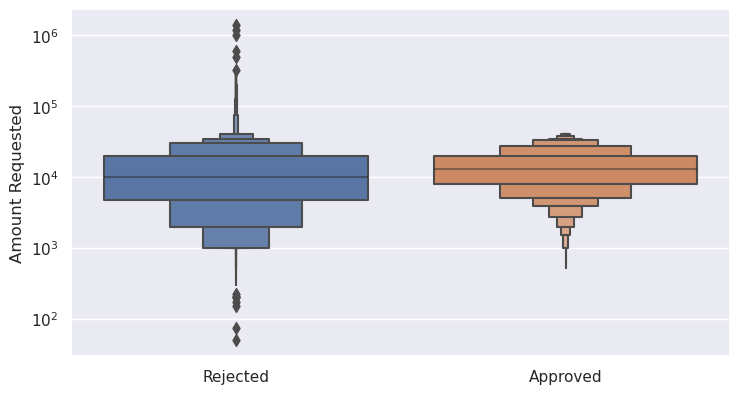

In [27]:
fig_requested_box, ax_requested_box = plt.subplots(figsize=BASE_FIG_SIZE)
sns.boxenplot(
    x=y_full_train.filter(X_full_eda["Amount Requested"].is_not_null()).to_numpy(),
    y=X_full_eda["Amount Requested"].drop_nulls().to_numpy(),
    ax=ax_requested_box
)
ax_requested_box.set_yscale("log")
ax_requested_box.set_ylabel("Amount Requested")
ax_requested_box.set_xticklabels(('Rejected','Approved'))
plt.show()

In [28]:
X_full_eda.null_count()

Amount Requested,Loan Title,Debt-To-Income Ratio,Zip Code,State,Employment Length,title_edited
u32,u32,u32,u32,u32,u32,u32
804,14786,1070,213,29,660310,3006175


##### Turn less than 0 into None

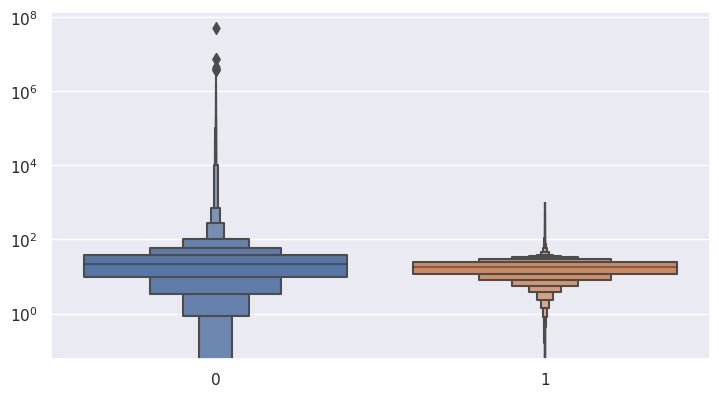

In [30]:
fig_dti_box, ax_dti_box = plt.subplots(figsize=BASE_FIG_SIZE)
sns.boxenplot(
    x=y_full_train.filter(X_full_eda["Debt-To-Income Ratio"].is_not_null()).to_numpy(),
    y=X_full_eda["Debt-To-Income Ratio"]
    .drop_nulls()
    .to_numpy(),

    ax=ax_dti_box
)

ax_dti_box.set_yscale("log")
plt.show()

In [31]:
dti_non_zero = (
    X_full_eda["Debt-To-Income Ratio"]
    .drop_nulls()
    .filter(X_full_eda["Debt-To-Income Ratio"].drop_nulls() != 0)
    .to_numpy()
)
dti_non_zero_y = y_full_train.filter(
    X_full_eda["Debt-To-Income Ratio"].is_not_null()
).filter(X_full_eda["Debt-To-Income Ratio"].drop_nulls() != 0)
dti_zero_x = (
    X_full_eda["Debt-To-Income Ratio"]
    .drop_nulls()
    .filter(X_full_eda["Debt-To-Income Ratio"].drop_nulls() == 0)
)
dti_zero_y = y_full_train.filter(
    X_full_eda["Debt-To-Income Ratio"].is_not_null()
).filter(X_full_eda["Debt-To-Income Ratio"].drop_nulls() == 0)

bins = dmf.create_bins((dti_non_zero), 50, log=True)

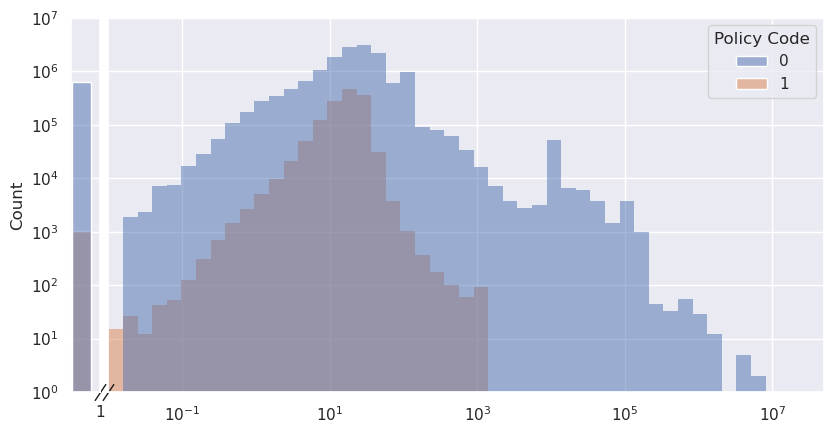

In [32]:
fig_dti_hist, ax_dti_hist = plt.subplots(
    1, 2, sharey=True, gridspec_kw={"width_ratios": [1, 25]}, figsize=BASE_FIG_SIZE
)

sns.histplot(x=dti_non_zero, bins=bins, hue=dti_non_zero_y, ax=ax_dti_hist[1])
ax_dti_hist[1].set_xscale("log")
ax_dti_hist[1].set_yscale("log")
ax_dti_hist[1].set_ylim(1, 1e7)
ax_dti_hist[1].set_xlim(bins[0], bins[-1])
sns.histplot(
    x=dti_zero_x.to_numpy(),
    bins=1,
    hue=dti_zero_y.to_numpy(),
    ax=ax_dti_hist[0],
    legend=False,
)

pf.plot_x_axis_break(ax_dti_hist[0],ax_dti_hist[1])

ax_dti_hist[0].set_xticks([1])

plt.tight_layout(w_pad=-0.5)
plt.show()

##### Number of zip codes with more  than 50k values"

In [36]:
X_full_eda["State"].value_counts().sort('counts')[-10:]["counts"].to_numpy(),

(array([ 555485,  562085,  652351,  655151,  675292,  695381, 1307041,
        1396802, 1610907, 2134242], dtype=uint32),)

In [37]:
state_counts=pl.DataFrame({'State':X_full_eda['State'],'accepted':y_full_train}).group_by('State').agg(
    pl.count().alias('Application Count'),
    (pl.sum('accepted')/pl.count()*100).alias('Accepted Percentage')
)

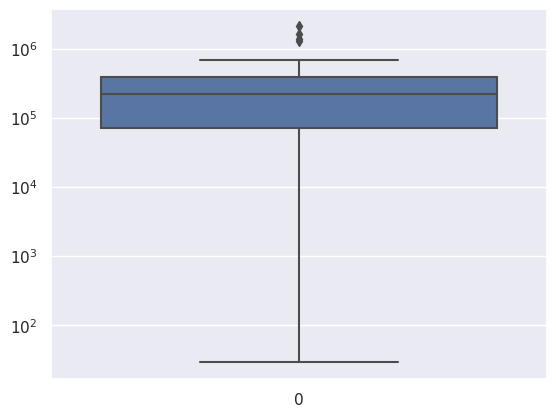

In [38]:
sns.boxplot(state_counts['Application Count'])
plt.yscale('log')

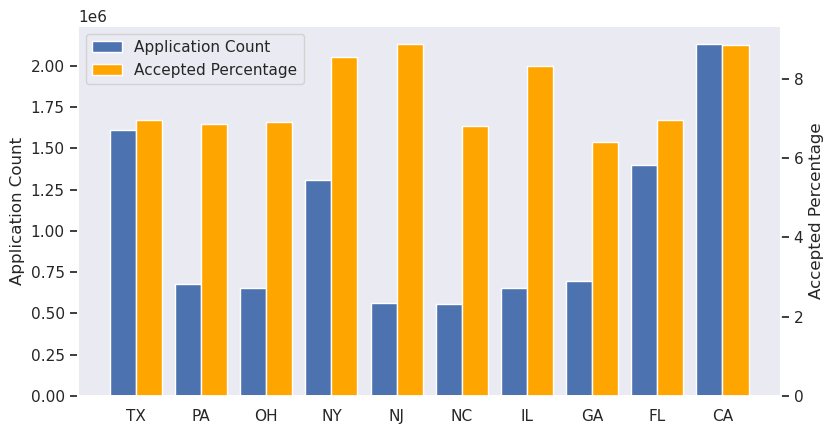

In [39]:
fig_state_counts, ax_state_counts = pf.plot_grouped_bars(
    state_counts, return_fig=True, top_vals=10,figsize_args={'figsize':BASE_FIG_SIZE}
)

In [40]:
work_time_counts=pl.DataFrame({'Employment Length':X_full_eda['Employment Length'],'accepted':y_full_train}).group_by('Employment Length').agg(
    pl.count().alias('Application Count'),
    (pl.sum('accepted')/pl.count()*100).alias('Accepted Percentage')
)
work_time_counts=work_time_counts.fill_null('None')

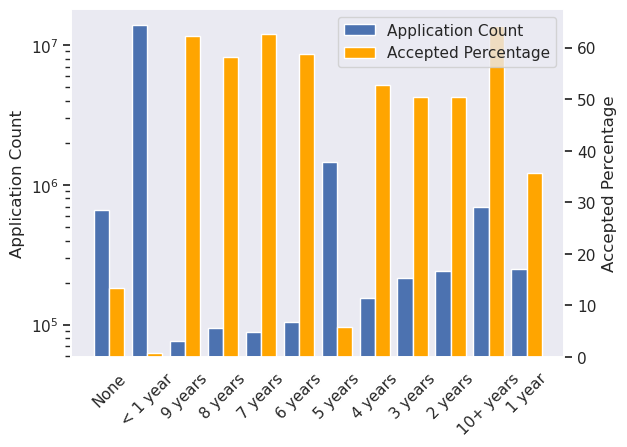

In [41]:
fig_emp_length, ax_empl_length = pf.plot_grouped_bars(
    work_time_counts, x_label_args={"rotation": 45}, return_fig=True
)

ax_empl_length[0].set_yscale('log')

In [25]:
numeric_columns = X_full_eda.select(pl.selectors.by_dtype(pl.NUMERIC_DTYPES)).columns
categorical_columns = [col for col in X_full_eda.columns if col not in numeric_columns]

In [26]:
numeric_columns_idx=[X_full_eda.columns.index(val) for val in numeric_columns]
categorical_column_idx=[X_full_eda.columns.index(val) for val in categorical_columns]

In [39]:
for col in categorical_columns:
    X_full_eda=X_full_eda.with_columns(pl.col(col).cast(pl.Categorical).alias(col))

In [40]:
X_full_eda

Amount Requested,Debt-To-Income Ratio,Zip Code,State,Employment Length,title_edited,title_contains_numbers,title_length
f64,f64,cat,cat,cat,cat,u32,u32
33000.0,23.219999,"""112xx""","""NY""","""< 1 year""","""debt_consolida…",0,18
5000.0,0.0,null,"""CA""","""< 1 year""","""moving""",0,21
6000.0,9.34,null,"""DE""","""5 years""","""major_purchase…",0,14
10000.0,3.96,null,"""WI""","""< 1 year""","""home""",0,11
12000.0,22.9,"""334xx""","""FL""","""1 year""","""debt_consolida…",0,18
1500.0,1.33,null,"""IL""",null,null,0,5
300000.0,null,"""337xx""","""FL""","""< 1 year""","""business""",0,13
10000.0,2.0,null,"""VA""",null,"""car""",0,13
20000.0,43.779999,null,"""CA""","""< 1 year""","""debt_consolida…",0,18


In [42]:
X_full_eda.write_parquet('X_full_eda.parquet')

In [19]:
X_full_eda = pl.read_parquet('X_full_eda.parquet')

In [43]:
sample= X_full_eda.with_columns(y_full_train.alias('y'))

In [44]:
sample=sample.sample(100000,seed=1)

In [49]:
from sklearn.preprocessing import LabelEncoder

In [52]:
labeler=LabelEncoder()

In [55]:
for col in categorical_columns:
    sample=sample.with_columns(pl.Series(labeler.fit_transform(sample[col])).alias(col))

In [53]:
labeler.fit_transform(sample['Zip Code'])

array([47, 74, 86, ..., 86, 86, 86])

In [58]:
import lightgbm as lgb
loan_classifier=lgb.LGBMClassifier(class_weight='balanced')

In [59]:
loan_classifier.fit(sample.drop(columns=['y']),sample['y'])

[LightGBM] [Info] Number of positive: 7563, number of negative: 92437
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced')

In [61]:
for col in categorical_columns:
    X_full_eda=X_full_eda.with_columns(pl.Series(labeler.fit_transform(X_full_eda[col])).alias(col))

In [62]:
from sklearn.metrics import classification_report

In [63]:
preds=loan_classifier.predict(X_full_eda)

In [64]:
print(classification_report(y_full_train,preds))

              precision    recall  f1-score   support

           0       0.92      0.51      0.65  16589244
           1       0.08      0.50      0.13   1356421

    accuracy                           0.51  17945665
   macro avg       0.50      0.50      0.39  17945665
weighted avg       0.86      0.51      0.61  17945665



In [65]:
loan_classifier.feature_importances_

array([648, 907, 380, 468, 198, 157,   1, 241], dtype=int32)

In [66]:
sample.columns

['Amount Requested',
 'Debt-To-Income Ratio',
 'Zip Code',
 'State',
 'Employment Length',
 'title_edited',
 'title_contains_numbers',
 'title_length',
 'y']

In [45]:
full_data_set_lgb = lgb.Dataset(
    sample.drop(columns=["y"]).to_numpy(),
    label=sample["y"].to_numpy(),
    categorical_feature=categorical_column_idx,
)

In [47]:
lgb_model = lgb.train(
    {"objective": "binary", "class_weights": "balanced"}, full_data_set_lgb
)

ValueError: could not convert string to float: '750xx'